In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import dotenv
dotenv.load_dotenv("/home/ckj24/rna-inverse-folding/.env")

True

In [2]:
import dotenv
dotenv.load_dotenv(".env")

import os
import random
import argparse
import wandb
import numpy as np
import pandas as pd

from lovely_numpy import lo
import lovely_tensors as lt
lt.monkey_patch()

import torch

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
# metadata for plotting results for Rosetta and FARNA from Das et al. 2011 paper.

das_list = [
    "1CSL",  # THE RRE HIGH AFFINITY SITE
    "1ET4",  # VITAMIN B12 BINDING RNA APTAMER WITH LIGAND AT 2.3 A
    "1F27",  # BIOTIN-BINDING RNA PSEUDOKNOT
    "1L2X",  # Viral RNA Pseudoknot
    "1LNT",  # Highly Conserved RNA Internal Loop of SRP
    "1Q9A",  # sarcin/ricin domain from E.coli 23S rRNA
    "4FE5",  # xpt-pbuX guanine riboswitch aptamer domain (ID 1U8D is now obsolete, replaced by ID 4FE5)
    "1X9C",  # all-RNA Hairpin Ribozyme with mutation U39C
    "1XPE",  # HIV-1 subtype B genomic RNA Dimerization Initiation Site
    "2GCS",  # Pre-cleavage state of the Thermoanaerobacter tengcongensis glmS ribozyme
    "2GDI",  # thiamine pyrophosphate-specific riboswitch in complex with thiamine pyrophosphate
    "2OEU",  # junctionless all-RNA hairpin ribozyme
    "2R8S",  # synthetic FAB bound to P4-P6 RNA ribozyme domain
    "354D",  # loop E FROM E. coli 5S RRNA
]

das_list_test_idx = {
    '1X9C': 1,
    '4FE5': 19,
    '2GDI': 52,
    '1L2X': 62,
    '2GCS': 66,
    '1ET4': 75,
    '1Q9A': 76,
    '2R8S': 84,
    '1XPE': 91,
    '1CSL': 93,
    '1LNT': 94,
    '1F27': 95,
    '2OEU': 96,
    '354D': 97
}

farna_recovery = [
    0.20,
    0.34,
    0.36,
    0.45,
    0.27,
    0.40,
    0.28,
    0.31,
    0.24,
    0.26,
    0.38,
    0.30,
    0.36,
    0.35,
]

rosetta_recovery = [
    0.44,
    0.44,
    0.37,
    0.48,
    0.53,
    0.41,
    0.36,
    0.50,
    0.40,
    0.44,
    0.48,
    0.37,
    0.53,
    0.55,
]

In [4]:
# models to be plotted
model_name_to_dir = {
    # non-autoregressive
    "NAR_8layer_128maxlen": "/home/ckj24/rna-inverse-folding/wandb/run-20240104_063415-onw9gfw7/",
    "NAR_8layer": "/home/ckj24/rna-inverse-folding/wandb/run-20240104_063415-7kcpksxc/",
    # autoregressive
    "AR_4layer_128maxlen": "/home/ckj24/rna-inverse-folding/wandb/run-20240103_203350-ejljpme5/",
    "AR_4layer": "/home/ckj24/rna-inverse-folding/wandb/run-20240103_220757-uf0h28bs/",
    # backbone-level models (P, C4', N1/9), for reference
    "ref-bb-feat_NAR_8layer": "/home/ckj24/rds/hpc-work/rna-inverse-folding/wandb/run-20240104_064020-me023cml/",
    "ref-bb-feat_AR_4layer": "/home/ckj24/rna-inverse-folding/wandb/run-20240104_062154-a8izzzbk/",
}

In [5]:
# load test set results for each model

df_residue = pd.DataFrame(columns=['idx', 'recovery', 'sasa', 'paired', 'rmsds', 'model_name', 'set'])

df_sample = pd.DataFrame(columns=['idx', 'mean_recovery', 'mean_scscore', 'model_name', 'set'])

for model_name, dir in model_name_to_dir.items():
    print(model_name)
    
    test_df, test_samples_list, test_recovery_list, test_scscore_list = torch.load(os.path.join(dir, "files", "test_results.pt"))
    test_df["model_name"] = model_name
    test_df["set"] = "test"
    
    df_residue = pd.concat([df_residue, test_df], axis=0)

    df_sample = pd.concat([df_sample, pd.DataFrame({
        "idx": list(range(len(test_recovery_list))),
        "mean_recovery": np.array(test_recovery_list),
        "mean_scscore": np.array(test_scscore_list),
        "model_name": [model_name] * len(test_recovery_list),
        "set": ["test"] * len(test_samples_list)
    })], axis=0)

    print(f"    TEST recovery: {np.mean(test_recovery_list):.4f} scscore: {np.mean(test_scscore_list):.4f}\n")

# observations
    # AR models have higher self-consistency scores than NAR models
    # both models have similar recovery scores, though we have trained 
    # NAR models with even higher recovery than what's obtained in the reference here
    # it seems recovery is not always correlated with self-consistency/designability


NAR_8layer_128maxlen
    TEST recovery: 0.3146 scscore: 0.4722

NAR_8layer
    TEST recovery: 0.4262 scscore: 0.5371

AR_4layer_128maxlen
    TEST recovery: 0.2947 scscore: 0.4913

AR_4layer
    TEST recovery: 0.4223 scscore: 0.7520

ref-bb-feat_NAR_8layer
    TEST recovery: 0.5316 scscore: 0.6112

ref-bb-feat_AR_4layer
    TEST recovery: 0.5315 scscore: 0.7239



In [6]:
# select only those indexes in das_list_test_idx.values()
df_sample_subset = df_sample[df_sample["idx"].isin(das_list_test_idx.values())].reset_index(drop=True)

# add Rosetta and FARNA results to df_sample_subset

df_sample_subset = pd.concat([df_sample_subset, pd.DataFrame({
    "idx": list(range(len(das_list))),
    "mean_recovery": np.array(farna_recovery),
    "mean_scscore": np.array([0] * len(das_list)),
    "model_name": ["FARNA"] * len(das_list),
    "set": ["test"] * len(das_list)
})], axis=0)

df_sample_subset = pd.concat([df_sample_subset, pd.DataFrame({
    "idx": list(range(len(das_list))),
    "mean_recovery": np.array(rosetta_recovery),
    "mean_scscore": np.array([0] * len(das_list)),
    "model_name": ["Rosetta"] * len(das_list),
    "set": ["test"] * len(das_list)
})], axis=0)

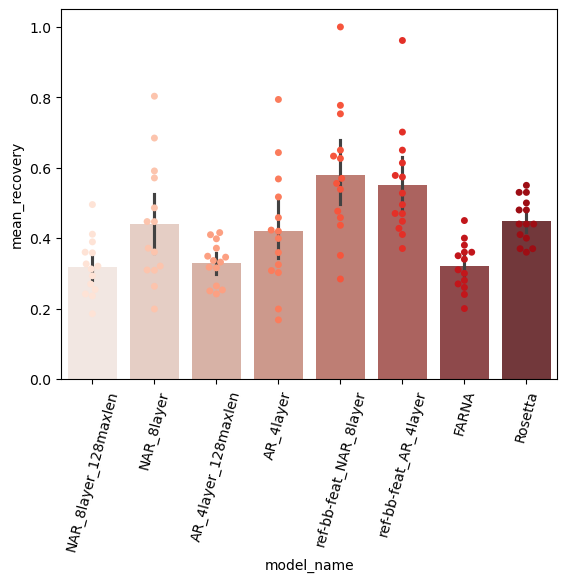

In [7]:
# bar plots comparing models to Rosetta and FARNA (only recovery is available)

sns.swarmplot(
    data = df_sample_subset,
    x="model_name",
    y="mean_recovery",
    # order = ["FARNA", "Rosetta", ...],
    # hue="set",
    palette="Reds",
)

sns.barplot(
    data = df_sample_subset,
    x="model_name",
    y="mean_recovery",
    # order = ["FARNA", "Rosetta", ...],
    # hue="set",
    saturation=0.4,
    palette="Reds",
)

# rotate x-axis labels
plt.xticks(rotation=75)

plt.show()

# observations
    # models with backbone-level featurisation can generally outperform Rosetta
    # however, C4' models may not always do so
    # perhaps this is due to loss of information/insufficient information

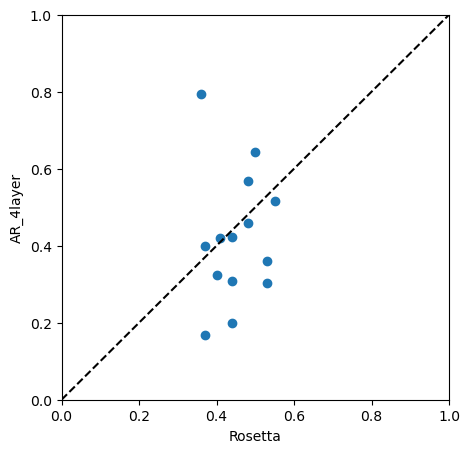

In [8]:
# scatterplot comparing Rosetta to models on individual test subset samples from the Das paper

model_x = "Rosetta"
model_y = "AR_4layer"
metric = "mean_recovery"

# figure size square
plt.figure(figsize=(5, 5))

# sns.scatterplot(
#     x = df_sample_subset[df_sample_subset.model_name == model_x][metric],
#     y = df_sample_subset[df_sample_subset.model_name == model_y][metric],
# )
plt.scatter(
    df_sample_subset[df_sample_subset.model_name == model_x][metric],
    df_sample_subset[df_sample_subset.model_name == model_y][metric],
)

# set model names as x and y axis labels
plt.xlabel(model_x)
plt.ylabel(model_y)

# set x and y axis range to 0-1
plt.xlim(0, 1)
plt.ylim(0, 1)

# draw a line from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="black")

plt.show()

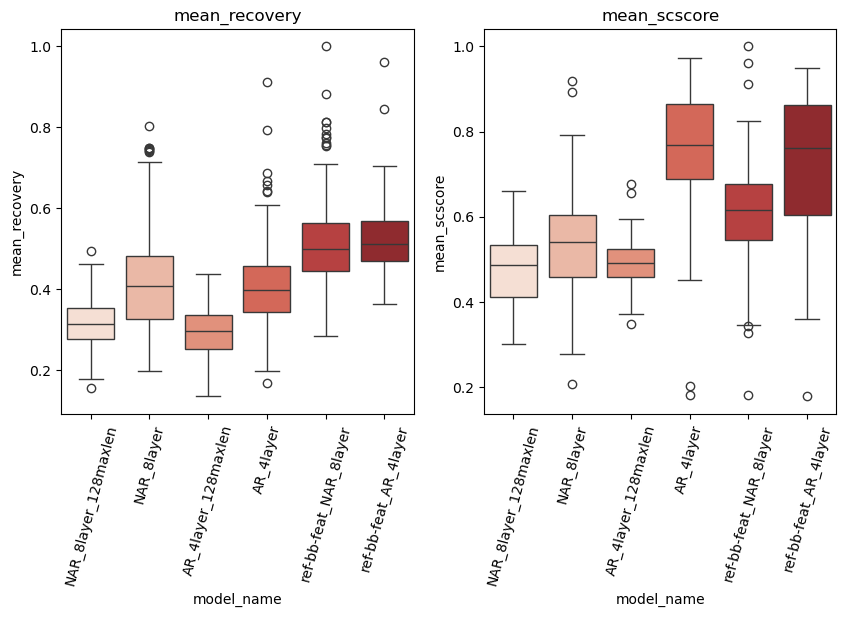

In [9]:
# boxplot comparing models on full test set

fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10, 5))
# fig.suptitle("title", fontsize=15)

for idx, metric in enumerate(["mean_recovery", "mean_scscore"]):
    sns.boxplot(
        data = df_sample,
        x="model_name",
        y=metric,
        # hue="set",
        saturation=0.65,
        palette="Reds",
        # whis=(0, 95),
        ax=ax[idx]
    )
    # ax[0].get_legend().set_visible(False)
    ax[idx].set_title(metric, multialignment="right")

    # rotate x-axis labels
    ax[idx].tick_params('x', labelrotation=75)

plt.show()

# observations
    # naturally, we notice a drop in all metrics when using C4' only models
    # not limiting training to short sequences seems very important for 
    # good performance even though test set contains RNAs < 150 nts
    # AR_4layer C4' model seems like the best choice for future projects 

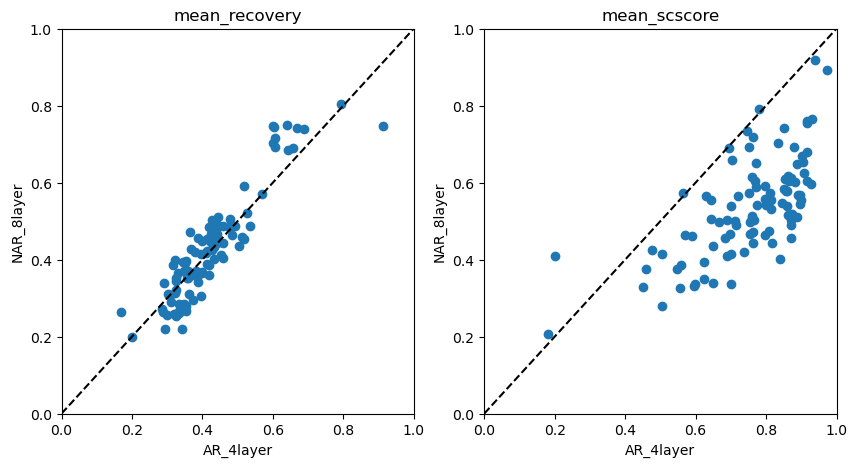

In [10]:
# scatterplot comparing models on individual samples from full test set

model_x = "AR_4layer"
model_y = "NAR_8layer"

fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10, 5))
# fig.suptitle("title", fontsize=15)

for idx, metric in enumerate(["mean_recovery", "mean_scscore"]):
    
    ax[idx].scatter(
        df_sample[df_sample.model_name == model_x][metric],
        df_sample[df_sample.model_name == model_y][metric],
    )

    ax[idx].set_title(metric, multialignment="right")
    
    # set model names as x and y axis labels
    ax[idx].set_xlabel(model_x)
    ax[idx].set_ylabel(model_y)

    # set x and y axis range to 0-1
    ax[idx].set_xlim(0, 1)
    ax[idx].set_ylim(0, 1)

    # draw a line from (0,0) to (1,1)
    ax[idx].plot([0, 1], [0, 1], ls="--", c="black")

plt.show()

# observations
    # clearly, both models are equally capable in terms of sequence recovery
    # but samples from the AR model seem more 'designable'
    # this is possibly b/c NAR models predict the probability distribution
    # for each nucleotide independently of others, whereas autoregressive
    # decoding accounts for previously decoded nucleotides in its sampling

array([[<Axes: title={'center': 'recovery'}>,
        <Axes: title={'center': 'sasa'}>],
       [<Axes: title={'center': 'paired'}>,
        <Axes: title={'center': 'rmsds'}>]], dtype=object)

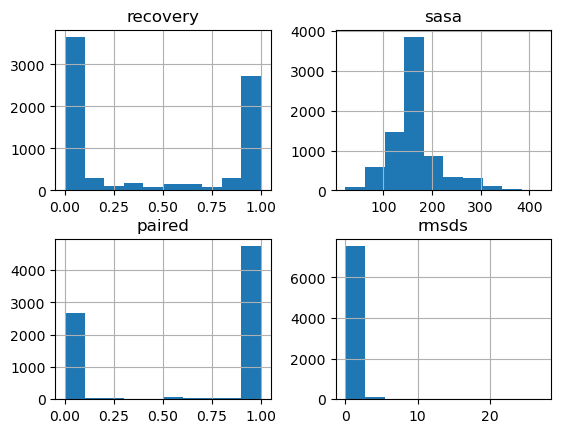

In [11]:
# overall histograms for residue level metrics
df_residue[df_residue.model_name == model_x].hist()

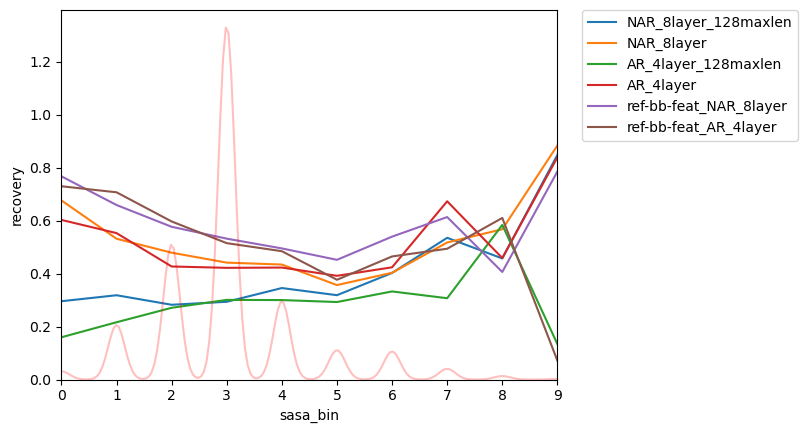

In [12]:
# recovery vs solvent accessable surface area of residue

# bin the values
num_bins = 10
df_residue['sasa_bin'] = pd.cut(df_residue['sasa'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='sasa_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="sasa_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
ax.set_xlim(0, num_bins - 1)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# observations
    # both AR and NAR models seem equally capable of recovering sequences
    # for 'burried' or 'core' nucleotides, but how predictive is SASA of
    # whether something is burried or on the core for RNA?

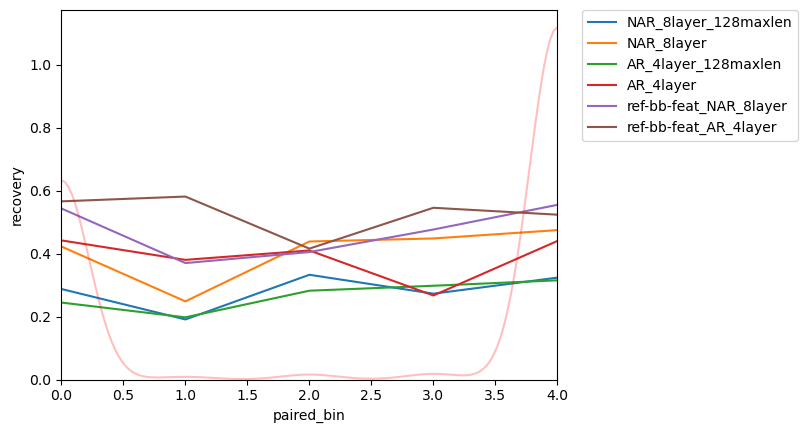

In [13]:
# recovery vs probability of residue being paired

# bin the values
num_bins = 5
df_residue['paired_bin'] = pd.cut(df_residue['paired'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='paired_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="paired_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
ax.set_xlim(0, num_bins - 1)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# observations
    # it seems it is equally challenging to recover paired and unpaired nucleotides
    # C4' only models have clearly lower performance here, but this is expected

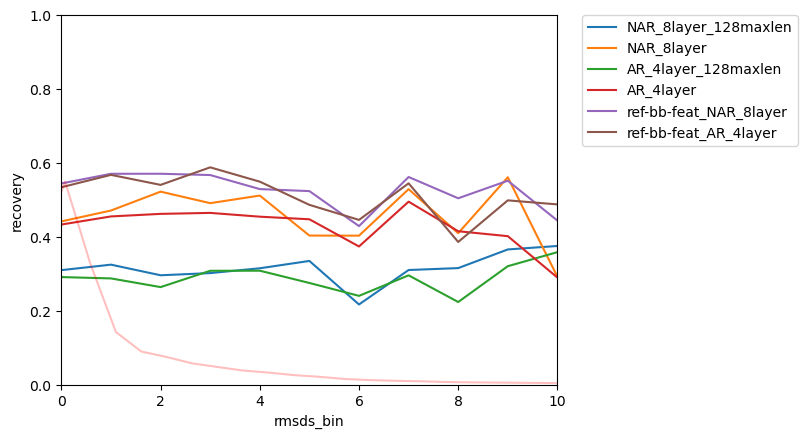

In [14]:
# recovery vs RMSD of residue if multiple structures are available

# bin the values
num_bins = 100
df_residue['rmsds_bin'] = pd.cut(df_residue['rmsds'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='rmsds_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="rmsds_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
# ax.set_xlim(0, num_bins - 1)
ax.set_xlim(0, 10)  # most of the later bins have very low density
ax.set_ylim(0, 1)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

array([[<Axes: title={'center': 'idx'}>,
        <Axes: title={'center': 'length'}>]], dtype=object)

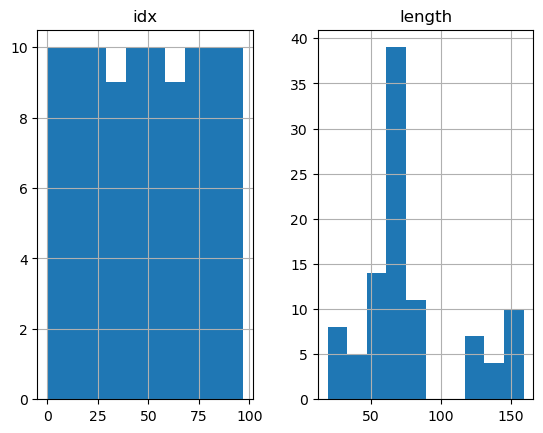

In [15]:
# for each unique combination of model_name, set, and idx, count the number of rows in df_residue with that combination

df_length = df_residue.groupby(["model_name", "set", "idx"]).count().reset_index()
df_length["length"] = df_length["recovery"]
df_length = df_length.drop(["recovery", "sasa", "paired", "rmsds", "sasa_bin", "paired_bin", "rmsds_bin"], axis=1)
df_length = df_length[df_length.model_name == model_x]
# use df_length to add length column to df_residue
df_residue["length"] = df_residue.apply(lambda row: df_length.loc[(df_length.set == row.set) & (df_length.idx == row.idx)].length.values[0], axis=1)
df_sample["length"] = df_length.length

df_length.hist()

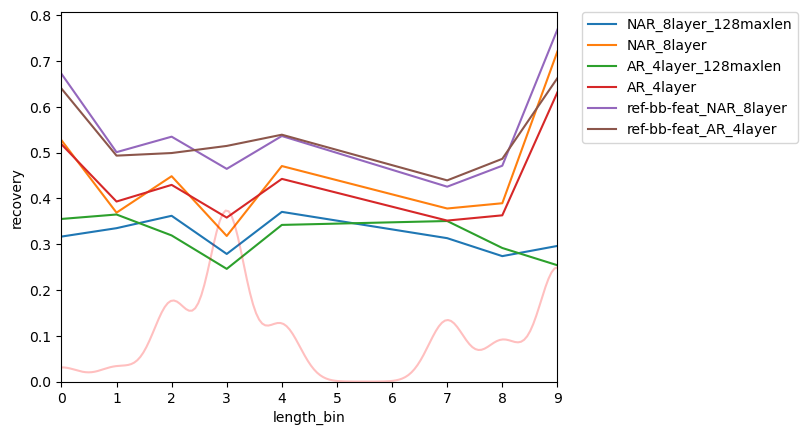

In [16]:
# residue-level recovery vs length of RNA sequence

# bin the values
num_bins = 10
df_residue['length_bin'] = pd.cut(df_residue['length'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='length_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="length_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
ax.set_xlim(0, num_bins - 1)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# observations
    # clearly, there is no advantage of training only on short sequences
    # more training data helps the model generalise far better
    # eventhough the test set only contains RNAs < 150 nts


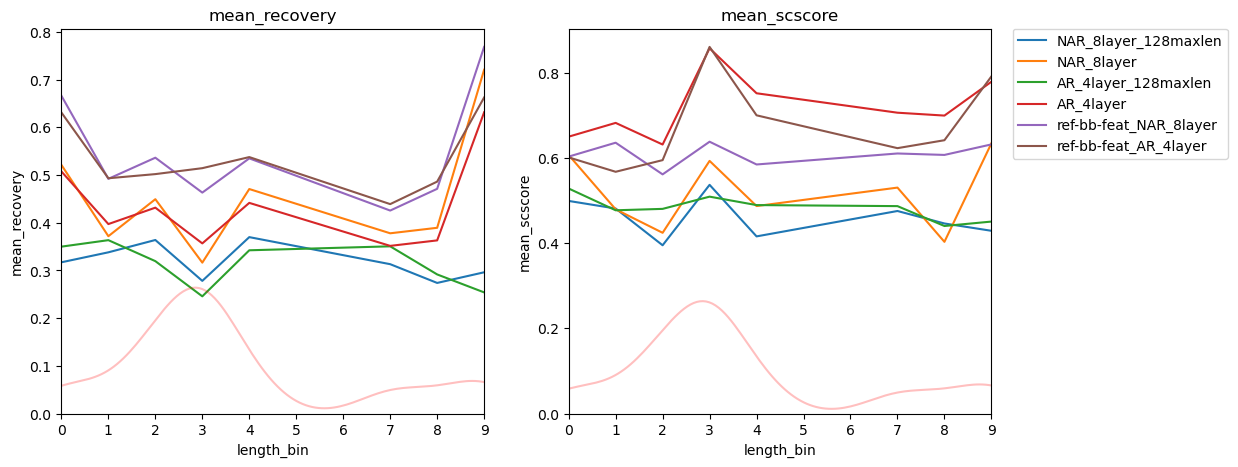

In [17]:
# sample-level recovery and scscore vs length of RNA sequence

fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12, 5))
# fig.suptitle("title", fontsize=15)

# bin the values
num_bins = 10
df_sample['length_bin'] = pd.cut(df_sample['length'], bins=num_bins, labels=False)

for idx, metric in enumerate(["mean_recovery", "mean_scscore"]):

    sns.lineplot(
        data=df_sample,
        x="length_bin",
        y=metric,
        hue="model_name",
        errorbar=None,
        ax=ax[idx]
    )
    sns.kdeplot(data=df_sample, x="length_bin", color='red', alpha=0.25, ax=ax[idx])

    ax[idx].set_title(metric, multialignment="right")

    # change x axis range
    ax[idx].set_xlim(0, num_bins - 1)

    ax[idx].get_legend().set_visible(False)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()